In [2]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('../../../../src')

In [5]:
from data import PolygonSentenceReader, Polygon
from modules import NLLLoss, ELBOLoss
from neural_process.models.np import CNP, LNP
from neural_process.models.attnnp import AttnCNP, AttnLNP
from transformer.models import TransformerDecoder
from utils import plot_polygon

import datetime
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.distributions.kl import kl_divergence

In [4]:
TRAINING_ITERATIONS = int(2e5)
PLOT_AFTER = int(2e4)
BATCH_SIZE = 128
MAX_CONTEXT_POINTS = 15
MIN_SIDES = 3
MAX_SIDES = 8
x_size = 4 + 3 * MAX_SIDES
y_size = MAX_SIDES
torch.manual_seed(0)

criterion = ELBOLoss()

# Instantiate a polygon generator.
# (For example, polygons with between 3 and 8 sides.)
polygon_generator_train = PolygonSentenceReader(
    batch_size=BATCH_SIZE,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES,
    max_num_sides=MAX_SIDES,
    center=(5, 5),
    radius=3,
    testing=False,
)

polygon_generator_test = PolygonSentenceReader(
    batch_size=100,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES,
    max_num_sides=MIN_SIDES,
    center=(5, 5),
    radius=3,
    testing=True,
)

model = LNP(x_dim=x_size, y_dim=y_size, r_dim=256, n_z_train=10, n_z_test=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=TRAINING_ITERATIONS, eta_min=1e-6
)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
device = next(model.parameters()).device
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


Total parameters: 1,533,712


# Training

In [4]:
train_losses = []
test_losses  = []
iters_list = []

# ----------------------
# Training Loop
# ----------------------
for it in range(1, TRAINING_ITERATIONS + 1):
    # Generate a batch of polygon completion tasks.
    (
        context_x,
        context_y,
        target_x,
        target_y,
        tokens,
        true_poly,
        max_seq_len,
        num_context,
        context_masks,
    ) = polygon_generator_train.generate_polygon_batch_few_shot_completion_task()

    context_x = context_x.to(device)
    context_y = context_y.to(device)
    target_x = target_x.to(device)
    target_y = target_y.to(device)
    context_masks = context_masks.to(device)

    optimizer.zero_grad()
    # Forward pass: the NP model expects context_x, context_y, target_x, target_y.
    dist, z, q_zc, q_zct = model(context_x, context_y, target_x, target_y)
    loss = criterion(dist, q_zct, q_zc, target_y, mask=context_masks)
    loss.backward()
    optimizer.step()
    scheduler.step()

    train_losses.append(loss.item())

    if it % 1000 == 0:
        print("Iteration: {}, train loss: {}".format(it, loss.item()))

    # ----------------------
    # Evaluation and Plotting
    # ----------------------
    if it % PLOT_AFTER == 0:
        # For plotting, we generate a single polygon sample.
        (
            context_x_eval,
            context_y_eval,
            target_x_eval,
            target_y_eval,
            tokens_eval,
            true_poly_eval,
            max_seq_len_eval,
            num_context_eval,
            context_masks_eval,
        ) = polygon_generator_test.generate_polygon_batch_few_shot_completion_task()

        context_x_eval = context_x_eval.to(device)
        context_y_eval = context_y_eval.to(device)
        target_x_eval = target_x_eval.to(device)
        target_y_eval = target_y_eval.to(device)
        context_masks_eval = context_masks_eval.to(device)

        # Forward pass through the model.
        test_dist, test_z, test_q_zc, test_q_zct = model(
            context_x_eval, context_y_eval, target_x_eval, target_y_eval
        )
        loss = criterion(test_dist, test_q_zct, test_q_zc, target_y_eval, mask=context_masks_eval)
        test_losses.append(loss.item())
        iters_list.append(it)

        print(
            "{}, Iteration: {}, Test Loss: {}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                it,
                loss.item(),
            )
        )

        # Get NP predictions on target tokens (taking the mean of the predictive distribution).
        pred_target = test_dist.mean  # shape: [n_z, batch, n_target, y_dim]

        # For simplicity, we average over latent samples and batch dimension.
        pred_target_avg = pred_target.mean(0)[0, -1, :]  # shape: [batch, n_target, y_dim]
        true_polygon = true_poly_eval[0]
        true_polygon_tokenised = true_polygon.to_tokenised()
        pred_target_avg = pred_target_avg[:len(true_polygon.angles)].tolist()

        print("True Polygon: ", true_polygon)
        print("True Polygon Angles: ", true_polygon.angles)
        print("Predicted Polygon Angles: ", pred_target_avg)

Iteration: 1000, train loss: 3137895680.0
Iteration: 2000, train loss: 798288256.0
Iteration: 3000, train loss: 329857728.0
Iteration: 4000, train loss: 89434760.0
Iteration: 5000, train loss: 59975992.0
Iteration: 6000, train loss: 23746080.0
Iteration: 7000, train loss: 12600618.0
Iteration: 8000, train loss: 12898991.0
Iteration: 9000, train loss: 12217497.0
Iteration: 10000, train loss: 27092814.0
Iteration: 11000, train loss: 5371109.5
Iteration: 12000, train loss: 8017843.5
Iteration: 13000, train loss: 30539372.0
Iteration: 14000, train loss: 2770408.75
Iteration: 15000, train loss: 1154464.25
Iteration: 16000, train loss: 1097069.375
Iteration: 17000, train loss: 1090873.875
Iteration: 18000, train loss: 34829188.0
Iteration: 19000, train loss: 4920608.5
Iteration: 20000, train loss: 1101752.375
2025-05-13 00:32:27, Iteration: 20000, Test Loss: 157488.984375
True Polygon:  Polygon(n=3, vertices=[(6.66, 7.5), (6.39, 7.66), (6.97, 2.74)], lengths=[0.31384709652950477, 4.954069034

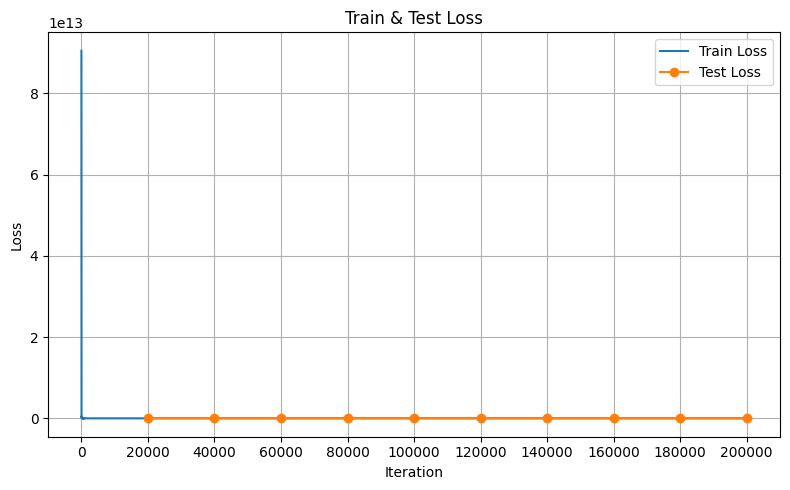

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(iters_list, test_losses, marker='o', label="Test Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Train & Test Loss")
plt.xticks(list(range(0, len(train_losses)+1, max(1, len(train_losses)//10))))  # optional: sparser x-ticks
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
checkpoint = {
    'iteration': it,                                 
    'model_state_dict': model.state_dict(),         
    'optimizer_state_dict': optimizer.state_dict(),  
    'scheduler_state_dict': scheduler.state_dict(),  
}

torch.save(model.state_dict(), "../models/polygon/np/angle_completion_task/" + model.__class__.__name__ + ".pt")
torch.save(checkpoint, "../models/polygon/np/" + model.__class__.__name__ + "_checkpoint.pt")
print(f"Saved final checkpoint at iteration {it} → ../models/polygon/np/" + model.__class__.__name__ + "_checkpoint.pt")

Saved final checkpoint at iteration 300000 → ../models/polygon/np/LNP_checkpoint.pt


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_dim = 1
y_dim = 1

np_model = LNP(x_dim=x_size, y_dim=y_size, r_dim=256, n_z_train=10, n_z_test=10)
np_model.load_state_dict(torch.load("../models/polygon/np/angle_completion_task/LNP.pt"))
np_model.eval()
np_model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"NP Total parameters: {total_params:,}")

# Reconstruct the Transformer model and load the trained checkpoint
tf_model = TransformerDecoder(x_dim, y_dim, r_dim=128, decoder_layers=8, decoder_heads=8)
checkpoint_path = f"../tf_model_1586561_params.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
tf_model.load_state_dict(checkpoint['model_state_dict'])
total_params = sum(p.numel() for p in tf_model.parameters())
print(f"TF Total parameters: {total_params:,}")
tf_model.eval()
tf_model.to(device)

NP Total parameters: 1,533,712


/vol/bitbucket/ls1221/fyp/fypenv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TF Total parameters: 1,586,561


TransformerDecoder(
  (project_r): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [8]:
import matplotlib.pyplot as plt
from math import fabs
import numpy as np
from data import EOS_TOKEN

In [9]:
def evaluate_neural_process_angle_completon_on_batch(
    model, ctx_x, ctx_y, tgt_x, tgt_y,
    true_polygons, max_seq_len, device
):
    """
    Few-shot angle completion with a Neural Process.
    """
    model.eval()
    with torch.no_grad():
        p_y_dist, z, q_zc, q_zct = model(
            ctx_x, ctx_y, tgt_x, None
        )
        mean_z = p_y_dist.mean.mean(dim=0)
        pred_y = mean_z.squeeze(1)
        
    B = pred_y.shape[0]
    all_abs, all_mae, all_sum = [], [], []

    for i in range(B):
        poly = true_polygons[i]
        n = poly.n
        true_angles = poly.angles

        # First n entries of the y-vector are the angles
        pred_vec = pred_y[i, -1, :].tolist()
        pred_angles = pred_vec[:n]

        # Per-angle absolute errors
        errs = [abs(p - t) for p,t in zip(pred_angles, true_angles)]
        all_abs.extend(errs)

        # Per-polygon MAE
        all_mae.append(sum(errs) / n)

        # Angle-sum error
        all_sum.append(abs(sum(pred_angles) - (n-2)*180.0))

    avg_abs_err = sum(all_abs) / len(all_abs)
    avg_angle_mae = sum(all_mae) / len(all_mae)
    avg_angle_sum_err= sum(all_sum) / len(all_sum)

    return avg_abs_err, avg_angle_mae, avg_angle_sum_err
    
def evaluate_transformer_angle_completion_on_batch(
    model, ctx_x, ctx_y, tgt_x, tgt_y,
    true_polygons, max_seq_len, device
):
    """
    Few-shot angle completion with a Transformer.
    """
    B, C, _ = ctx_x.shape
    _, _, L_angles = tgt_y.shape

    total_abs_err = 0.0
    total_count = 0
    all_preds = []
    all_trues = []

    model.eval()
    with torch.no_grad():
        for i in range(B):
            # Build prompt
            prompt = []
            for j in range(C):
                toks = ctx_x[i,j].tolist()
                while toks and toks[-1]==0.0: toks.pop()
                prompt += toks
                toks = ctx_y[i,j].tolist()
                while toks and toks[-1]==0.0: toks.pop()
                prompt += toks
                prompt.append(EOS_TOKEN)

            partial = tgt_x[i,0].tolist()
            while partial and partial[-1]==0.0: partial.pop()
            prompt += partial

            prompt_len = len(prompt)

            # Autoregressive loop
            generated = prompt.copy()
            for _ in range(L_angles):
                if len(generated) > max_seq_len:
                    generated = generated[-max_seq_len:]
                inp = (
                    torch.tensor(generated, device=device)
                         .unsqueeze(1).unsqueeze(-1)
                )  # [seq_len, 1, 1]
                logits = model(inp)    # → same shape
                nxt = logits[-1, 0, 0].item()
                generated.append(nxt)

            # Slice out predictions
            true_angles = true_polygons[i].angles
            n = true_polygons[i].n
            pred_angles = generated[len(prompt): len(prompt)+n]

            # Accumulate
            for p,t in zip(pred_angles, true_angles):
                total_abs_err += abs(p - t)
            total_count += n

            all_preds.append(pred_angles)
            all_trues.append(true_angles)

    avg_abs_err = total_abs_err / total_count
    angle_maes = [
        sum(abs(p - t) for p,t in zip(p_list, t_list)) / len(t_list)
        for p_list, t_list in zip(all_preds, all_trues)
    ]
    angle_sum_errs = [
        fabs(sum(p_list) - (len(p_list)-2)*180.0)
        for p_list in all_preds
    ]
    
    avg_angle_mae = sum(angle_maes) / len(angle_maes)
    avg_angle_sum_err = sum(angle_sum_errs) / len(angle_sum_errs)

    return (
        avg_abs_err,
        avg_angle_mae,
        avg_angle_sum_err,
    )

In [10]:
def compare_models_shared_data(reader, np_model, tf_model, tf_max_seq_len, context_sizes, runs_per_size, device):
    """
    Compare NP and Transformer on same sampled tasks.
    """
    results = {'NP': {}, 'TF': {}}
    
    np_model.to(device).eval()
    tf_model.to(device).eval()

    for c in context_sizes:
        errs_np, maes_np, sums_np = [], [], []
        errs_tf, maes_tf, sums_tf = [], [], []

        for _ in range(runs_per_size):
            # Generate a single batch of tasks (shared data)
            (ctx_x, ctx_y, tgt_x, tgt_y,
             tokens, true_polys, max_seq_len, _, _) = reader.generate_polygon_batch_few_shot_completion_task(c)

            ctx_x, ctx_y = ctx_x.to(device), ctx_y.to(device)
            tgt_x, tgt_y = tgt_x.to(device), tgt_y.to(device)

            # -- Neural Process evaluation --
            avg_np, mae_np, sum_np = evaluate_neural_process_angle_completon_on_batch(
                np_model, ctx_x, ctx_y, tgt_x, tgt_y, true_polys, max_seq_len, device
            )
            errs_np.append(avg_np); maes_np.append(mae_np); sums_np.append(sum_np)

            # -- Transformer evaluation --
            avg_tf, mae_tf, sum_tf = evaluate_transformer_angle_completion_on_batch(
                tf_model, ctx_x, ctx_y, tgt_x, tgt_y, true_polys, tf_max_seq_len, device
            )
            errs_tf.append(avg_tf); maes_tf.append(mae_tf); sums_tf.append(sum_tf)

        results['NP'][c] = {
            'abs_err': np.mean(errs_np),
            'angle_mae': np.mean(maes_np),
            'angle_sum': np.mean(sums_np),
        }
        results['TF'][c] = {
            'abs_err': np.mean(errs_tf),
            'angle_mae': np.mean(maes_tf),
            'angle_sum': np.mean(sums_tf),
        }

    # Plot results
    for metric, ylabel in [
        ('abs_err', 'Average Absolute Angle Error'),
        ('angle_mae', 'Angle MAE'),
        ('angle_sum', 'Angle Sum Error'),
    ]:
        plt.figure(figsize=(7,4))
        for name, marker in [('NP','-o'), ('TF','-s')]:
            ys = [results[name][c][metric] for c in context_sizes]
            plt.plot(context_sizes, ys, marker, label=name)
        plt.xlabel("Number of Context Points")
        plt.ylabel(ylabel)
        plt.xticks(context_sizes)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


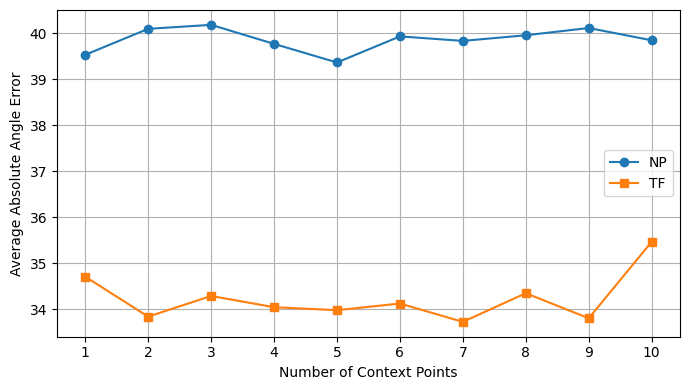

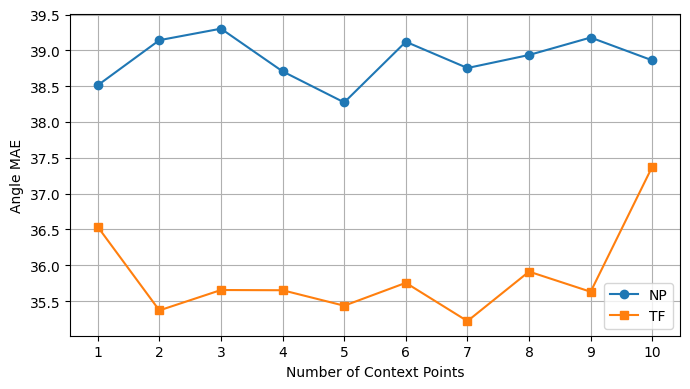

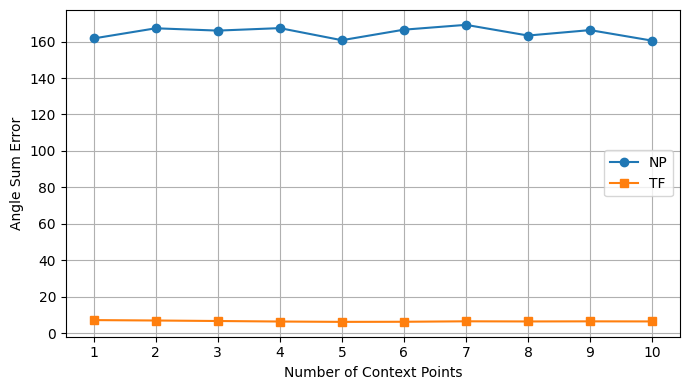

In [20]:
polygon_generator_eval = PolygonSentenceReader(
    batch_size=128,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES,
    max_num_sides=MAX_SIDES,
    center=(5, 5),
    radius=3,
    testing=True,
)

context_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
runs_per_size = 10
tf_max_seq_len = 512

compare_models_shared_data(polygon_generator_eval, np_model, tf_model, tf_max_seq_len, context_sizes, runs_per_size, device)

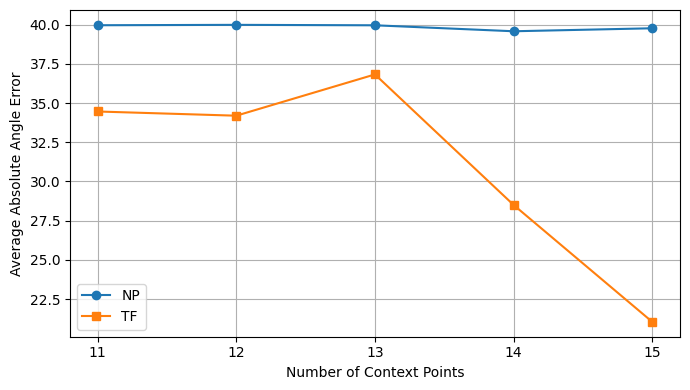

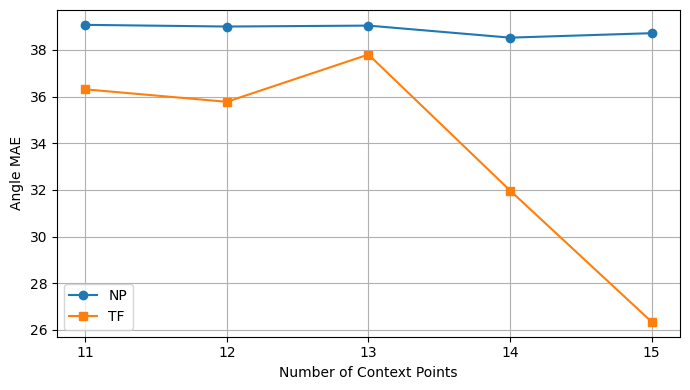

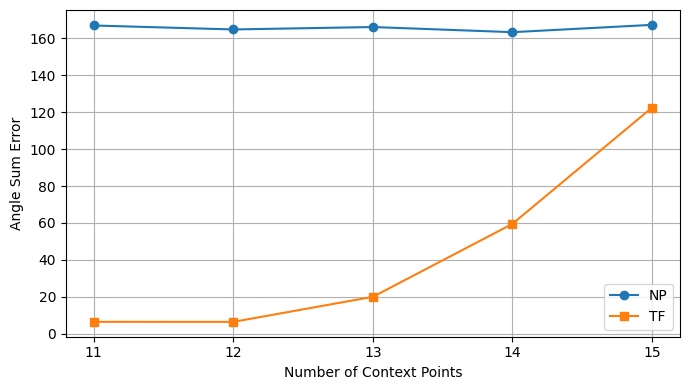

In [17]:
polygon_generator_eval = PolygonSentenceReader(
    batch_size=128,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES,
    max_num_sides=MAX_SIDES,
    center=(5, 5),
    radius=3,
    testing=True,
)

context_sizes = [11, 12, 13, 14, 15]
runs_per_size = 10
tf_max_seq_len = 512

compare_models_shared_data(polygon_generator_eval, np_model, tf_model, tf_max_seq_len, context_sizes, runs_per_size, device)

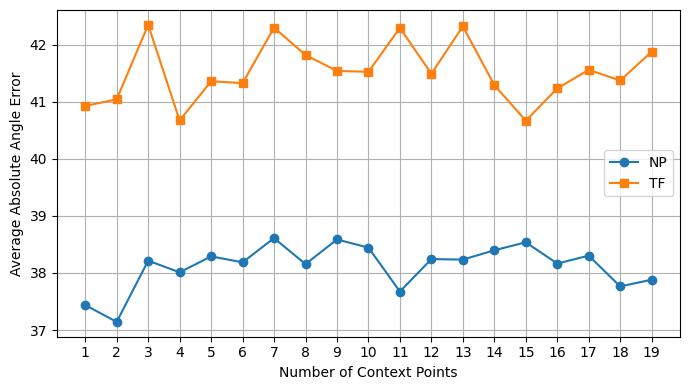

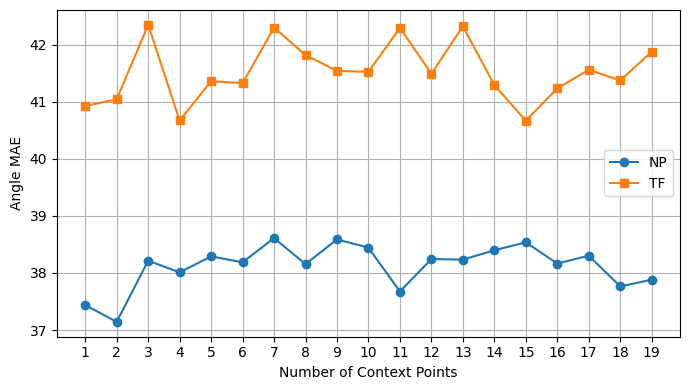

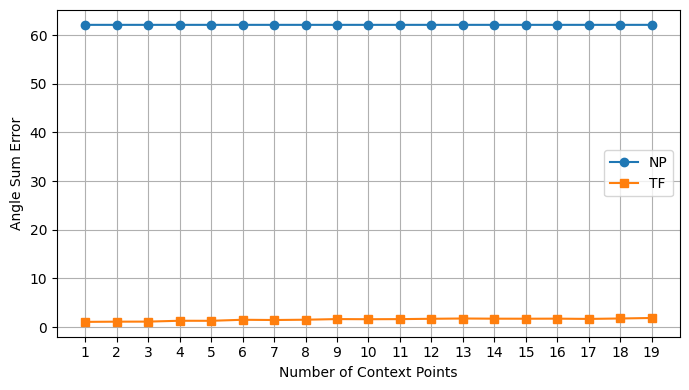

In [18]:
polygon_generator_eval = PolygonSentenceReader(
    batch_size=128,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=3,
    max_num_sides=3,
    center=(5, 5),
    radius=3,
    testing=True,
)

context_sizes = range(1, 20)
runs_per_size = 10
tf_max_seq_len = 512

compare_models_shared_data(polygon_generator_eval, np_model, tf_model, tf_max_seq_len, context_sizes, runs_per_size, device)

# Context size performance over various shapes

Evaluating for 3 sides


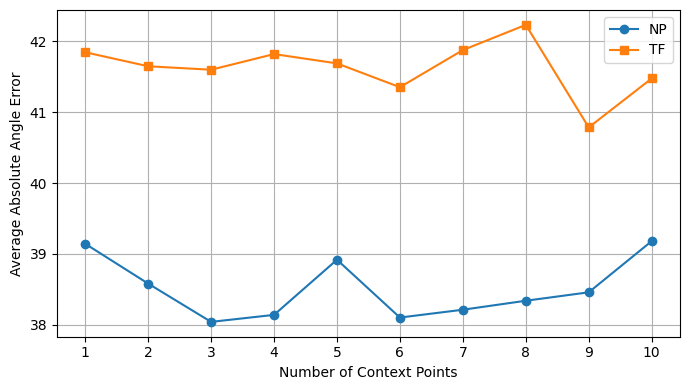

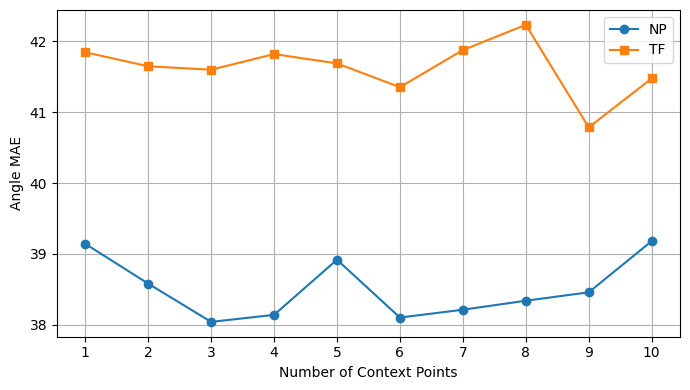

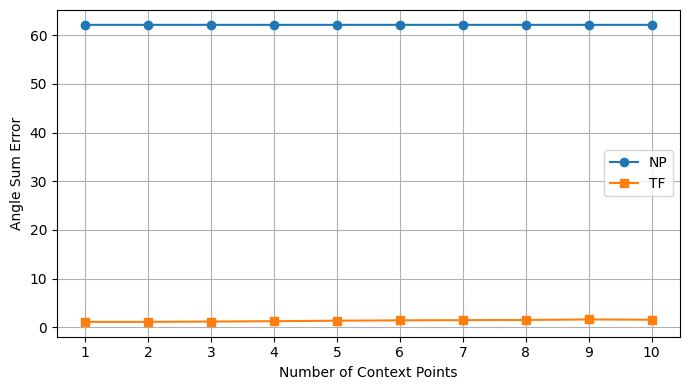

Evaluating for 4 sides


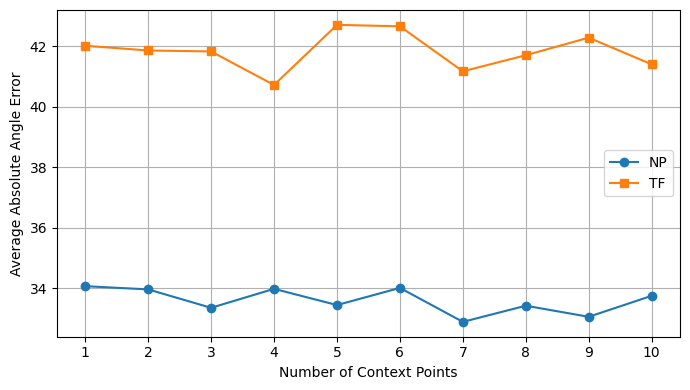

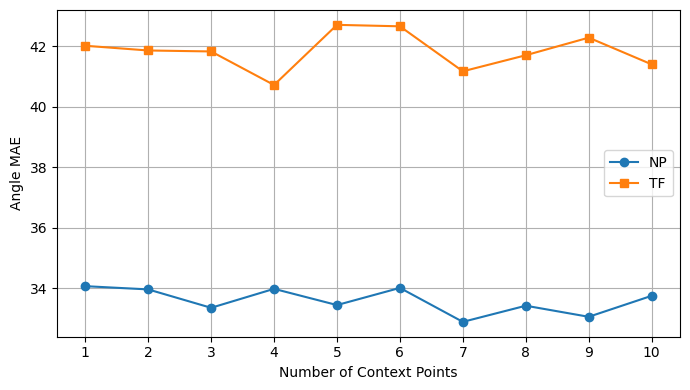

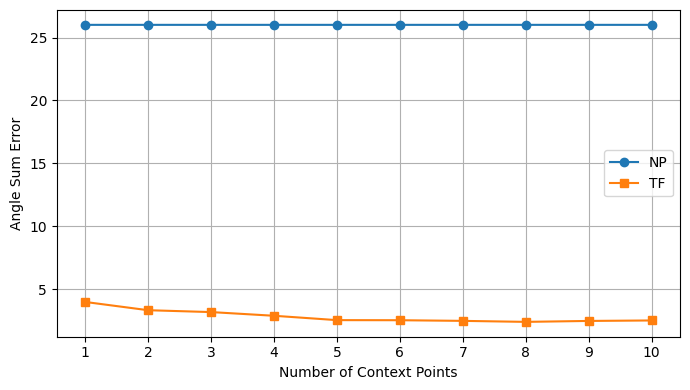

Evaluating for 5 sides


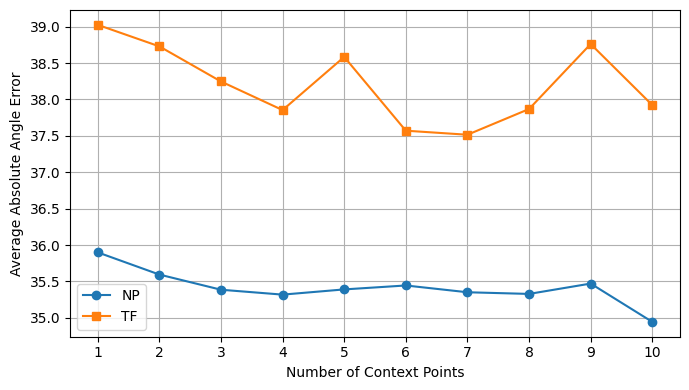

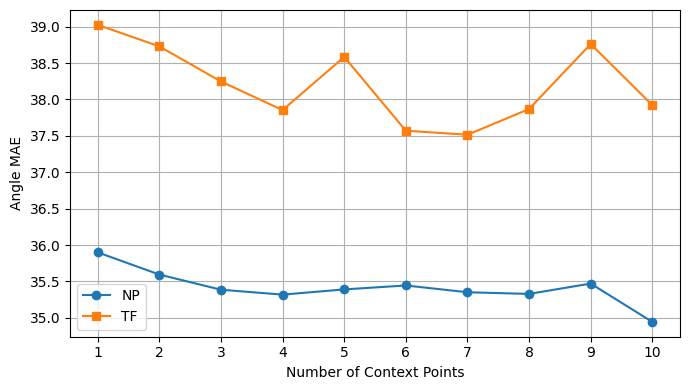

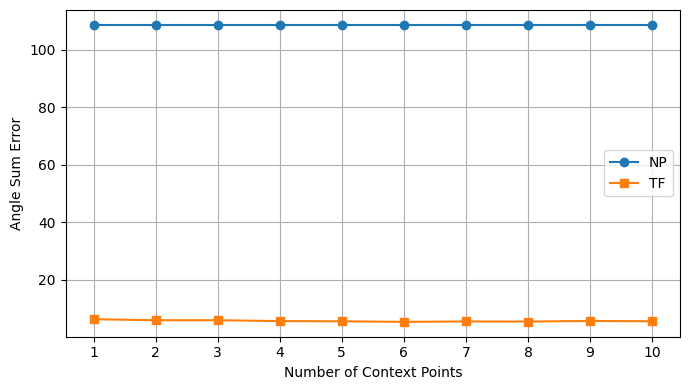

Evaluating for 6 sides


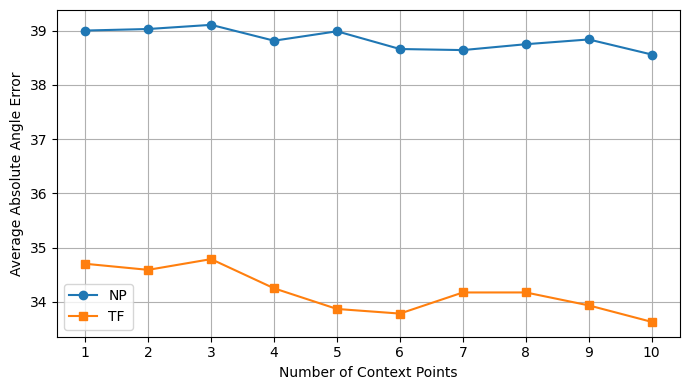

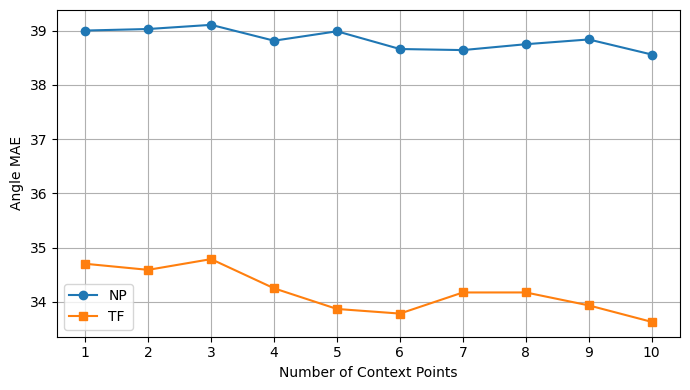

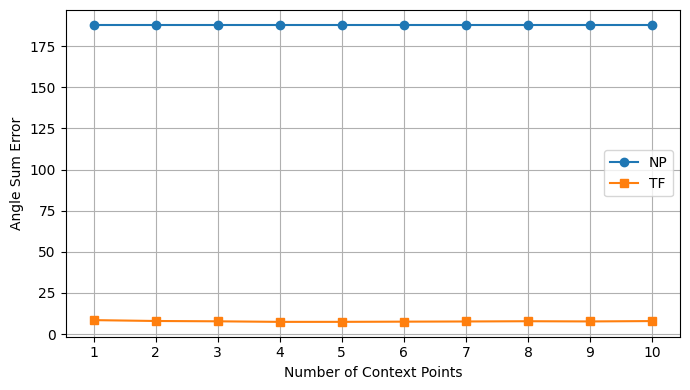

Evaluating for 7 sides


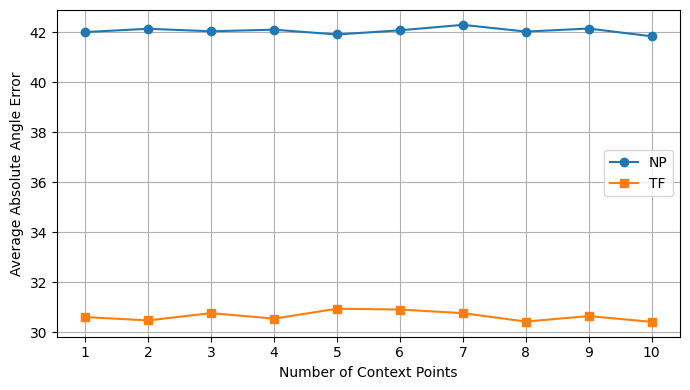

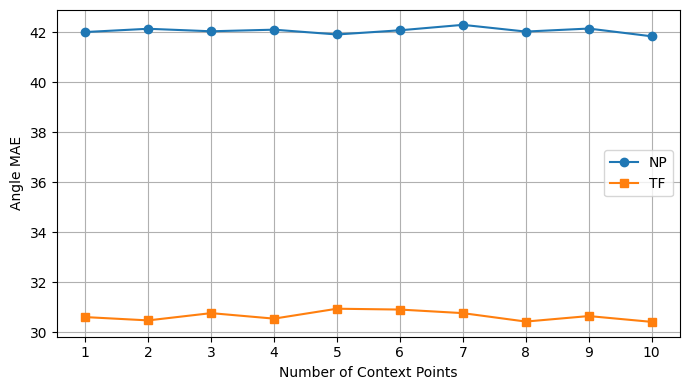

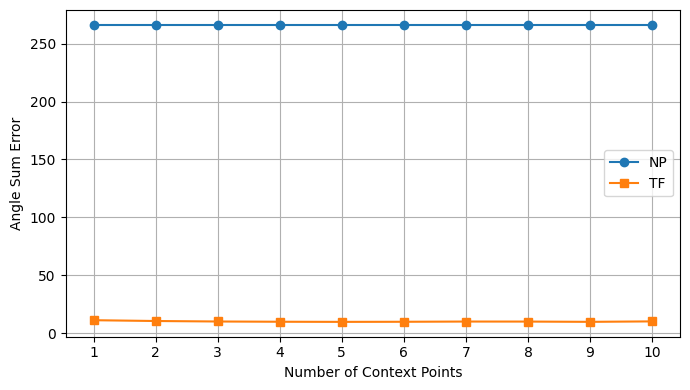

Evaluating for 8 sides


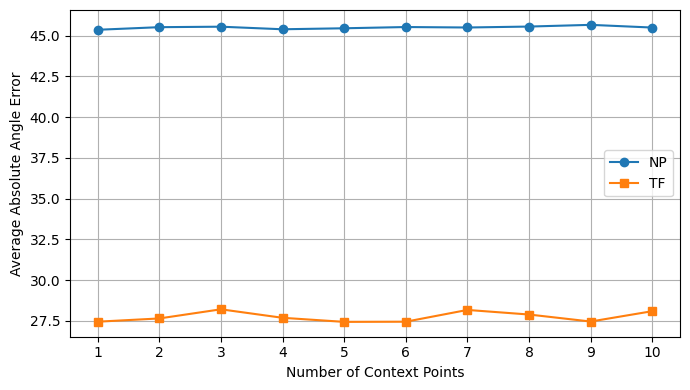

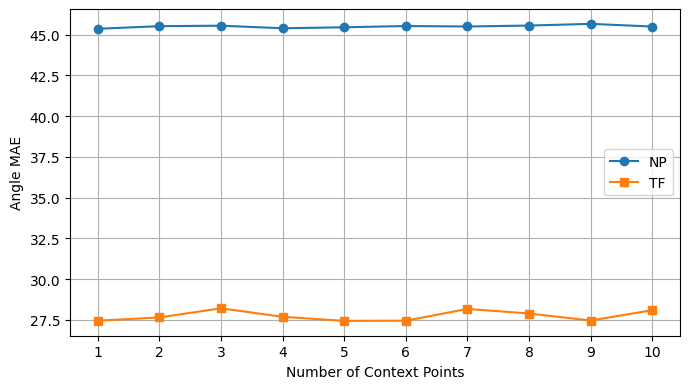

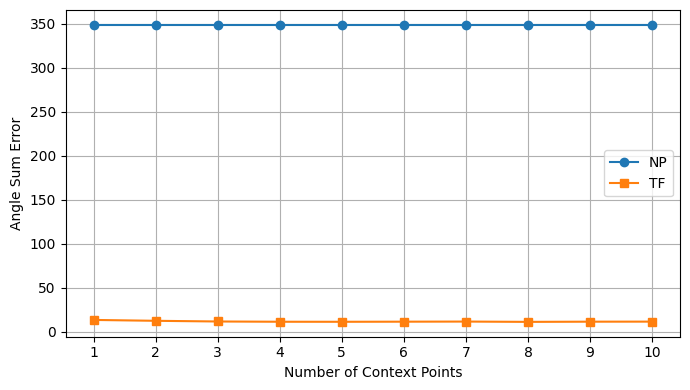

In [12]:
sides = range(3, 9)
for s in sides:
    print("=" * 50)
    print(f"Evaluating for {s} sides")

    polygon_generator_eval = PolygonSentenceReader(
        batch_size=128,
        max_num_context=MAX_CONTEXT_POINTS,
        max_seq_len=x_size,
        min_num_sides=s,
        max_num_sides=s,
        center=(5, 5),
        radius=3,
        testing=True,
    )

    context_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    runs_per_size = 10
    tf_max_seq_len = 512

    compare_models_shared_data(polygon_generator_eval, np_model, tf_model, tf_max_seq_len, context_sizes, runs_per_size, device)